# Title
- When you feel you need to use function in general, then there is a natural barier here and you should write it into script and import it

<!--- ![alt text](/home/patrik/pcflow/drawio/images/code.drawio.png) -->





# Start Metric
- Just for future evals
- Create persistent structure


- [x] To keep attention
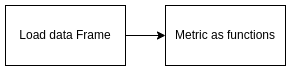

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from vis.deprecated_vis import *
import glob
from data.PATHS import DATA_PATH, TMP_VIS_PATH

# Load data

# TESTING PIPELINE
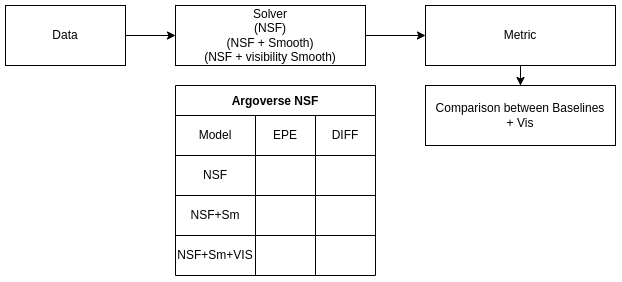

In [2]:
from ops.metric import scene_flow_metrics
from data.NSF_data import Argo1_NSF
# design loop here, then refactor to a function later --- nice


# baseline_nsf

from models.FastNSF import optimization

baseline_net_prior = optimization.Neural_Prior()


In [5]:
### deprecated, copy from pipeline.sceneflow.py to continue development
device = 'cuda:0'
baseline_net_prior.to(device)

nsf_dataloader = Argo1_NSF()

outputs = []

# for development
import importlib
importlib.reload(optimization)
solver_no_opt = optimization.solver_no_opt

for batch_id, data in enumerate(nsf_dataloader):

    if batch_id != 2: continue


    pc1, pc2, gt_flow = data
    # print(pc1.norm(dim=-1).max())

    pc1 = pc1.to(device)
    pc2 = pc2.to(device)
    gt_flow = gt_flow.to(device)

    radius_mask = pc1.norm(dim=-1) < 35
    radius_mask2 = pc2.norm(dim=-1) < 35

    pc1 = pc1[:,radius_mask[0]]
    pc2 = pc2[:,radius_mask2[0]]
    gt_flow = gt_flow[:,radius_mask[0]]

    # FNSF baseline
    # pred_dict = solver_no_opt(pc1, pc2, gt_flow, baseline_net_prior, 1500,)

    # Smoothness loss
    # pred_dict = solver_no_opt(pc1, pc2, gt_flow, baseline_net_prior, 1500,
    #                           use_smoothness=True)

    # Visibility Smoothness loss
    pred_dict = solver_no_opt(pc1, pc2, gt_flow, baseline_net_prior, 1500,
                              use_smoothness=True, use_visibility_smoothness=True)

    # Forward flow smoothness
    # pred_dict = solver_no_opt(pc1, pc2, gt_flow, baseline_net_prior, 1500,
    #                           use_smoothness=True, use_forward_flow_smoothness=True)

    pred_flow = pred_dict['final_flow']


    # EPE3D, acc3d_strict, acc3d_relax, outlier, angle_error = scene_flow_metrics(gt_flow, )

    store_dict = {'loss' : pred_dict['loss'],
                  'EPE3D' : pred_dict['EPE3D_1'],
                  'acc3d_strict' : pred_dict['acc3d_strict_1'],
                  'acc3d_relax' : pred_dict['acc3d_relax_1'],
                  'angle_error' : pred_dict['angle_error_1'],
                  'outlier' : pred_dict['outlier_1']}
    # print(EPE3D)
    # break
    outputs.append(dict(list(store_dict.items())[1:]))


Average time for solver_timer: 21.774077653884888


In [4]:
# TODO first try smooth afterflow 1NN? As a refinement only to achieve speed? One KNN after flow convergence and then smooth it?  [x] Implemented

# TODO first do visibility? Range image, arbitrary even, just to show you can do it without slowing down [x] Implemented

# TODO Iterate experiments [x] Implemented, further expansion possible

# TODO Reverse NN? Is the same as Chamfer in both direction? Not sure if novelty - find out exactly [x] Implemented

# Use Case for NN Flow
Argoverse1 NSF - frame 2
<img src="/home/patrik/pcflow/use_cases/Smooth_NN_from_flow.png" width=600>

In [6]:
import pandas as pd
df = pd.DataFrame(outputs)
df.loc['mean'] = df.mean()

print(df.mean())

EPE3D           0.077133
acc3d_strict    0.701785
acc3d_relax     0.847706
angle_error     0.062199
outlier         0.282385
dtype: float64


# To visualize DT loss on the point cloud

In [6]:
# visualize_points3D(pc2[0], per_point_DT_loss)

# visualize_points3D(pc2[0], per_point_reverse_dt_loss)
# visualize_points3D(pc1[0], per_point_smooth_loss)
# visualize_points3D(pc1[0], per_point_forward_smooth_loss)


In [8]:

# visualize_flow3d(pc1, pc2[:,:1], pred_flow)
visualize_flow3d(pc1, pc2, pred_flow)
# visualize_points3D(pc1[0] + pred_flow[0], error)

error = (gt_flow - pred_flow).norm(dim=-1)[0]
visualize_points3D(pc1[0], error)
# visualize_points3D(pc1[0], torch.clip(per_point_DT_loss, 0, 3))
# visualize_flow3d(pc1, pc2, gt_flow - pred_flow)

yaw_angle = torch.atan2(pc1[0,:,1], pc1[0,:,0])
pitch_angle = torch.arcsin(pc1[0,:,2] / pc1[0].norm(dim=-1))

# visualize_multiple_pcls(*[pc1[0].detach().cpu(),
#                           (pc1[0] + pred_flow[0]).detach().cpu(),
#                            pc2[0].detach().cpu()])

# visualize_points3D(pc1[0], yaw_angle)
# visualize_points3D(pc1[0], pitch_angle)
# from vis.mayavi_interactive import visualize_flow_frame



In [8]:
pc1_min = torch.min(pc1.squeeze(0), 0)[0]
pc2_min = torch.min(pc2.squeeze(0), 0)[0]
pc1_max = torch.max(pc1.squeeze(0), 0)[0]
pc2_max = torch.max(pc2.squeeze(0), 0)[0]

xmin_int, ymin_int, zmin_int = torch.floor(
    torch.where(pc1_min < pc2_min, pc1_min, pc2_min) * 10 - 1) / 10
xmax_int, ymax_int, zmax_int = torch.ceil(
    torch.where(pc1_max > pc2_max, pc1_max, pc2_max) * 10 + 1) / 10

from models.FastNSF.optimization import DT


pc1_deformed = pc1 + pred_flow

# change to see reverse direction (original is pc1)
dt = DT((pc1_deformed).clone().squeeze(0).to(pc1.device), (xmin_int, ymin_int, zmin_int), (xmax_int, ymax_int, zmax_int),
            10, pc1.device)

# per_point_DT_loss = dt.torch_bilinear_distance(pc1_deformed.squeeze(0))
per_point_DT_loss = dt.torch_bilinear_distance(pc2.squeeze(0))
print(pred_dict.keys())
# per_point_reverse_dt_loss = pred_dict['per_point_reverse_dt_loss']
# per_point_smooth_loss = pred_dict['per_point_smooth_loss'][0]
# per_point_forward_smooth_loss = pred_dict['per_point_forward_smooth_loss'][0]


dict_keys(['final_flow', 'loss', 'EPE3D_1', 'acc3d_strict_1', 'acc3d_relax_1', 'angle_error_1', 'outlier_1', 'time', 'epoch', 'solver_time', 'pre_compute_time', 'build_dt_time', 'dt_query_time', 'avg_dt_query_time', 'network_time', 'avg_net_time', 'net_backward_time', 'avg_net_backward_time', 'per_point_smooth_loss'])


In [9]:


# run exps with visibility smoothness

# parametrized Loss
# Input args in general for init
# Input for forward (pc1, pc2, pred_flow, gt_flow)
# will build loss class that is initialized inside optimization function
# weights inside the model
# add to equation with loss = previous_loss + loss_class

# opsat to?
# bash params: L_FS_weight, L_FS_KNN, L_FS_max_radius
# then parse argparser? args.L_FS_weight
import argparse

w_FS = 1.
K_FS = 12
max_radius_FS = 1

args = argparse.Namespace()

args.loss = {}
args.loss['flow_smooth_loss'] = {}
args.loss['flow_smooth_loss']['weight'] = w_FS
args.loss['flow_smooth_loss']['K'] = K_FS
args.loss['flow_smooth_loss']['max_radius'] = max_radius_FS

print(args)

# argparser, can be tranformed even between config file
# each loss takes specific args, args for abstract class receive name of loss dict

# jaka je struktura input argumentu? argparse?


Namespace(loss={'flow_smooth_loss': {'weight': 1.0, 'K': 12, 'max_radius': 1}})


In [10]:
# plt.plot(pc1[0,:,0].detach().cpu(), pc1[0,:,1].detach().cpu(), 'o')
# plt.axis('equal')
# plt.savefig(TMP_VIS_PATH + '/plot.png')

In [11]:

# # Classa asi zbytecna ...
# class UnsupervisedLoss(torch.nn.Module):
#
#     def __init__(self, pc1, pc2, pred_flow, *args, **kwargs):
#         super(UnsupervisedLoss, self).__init__()
#
#         self.loss_functions = []
#
#         if 'flow_smooth_loss' in kwargs.keys():
#
#             from loss.flow import FlowSmoothLoss
#             self.FlowSmooth = FlowSmoothLoss(pc1, **kwargs['flow_smooth_loss'])
#
#             self.loss_functions.append(self.FlowSmooth)
#
#             for k,v in kwargs.items():
#
#                 print(k,v)
#
    # def forward(self, pc1, pc2, pred_flow, gt_flow):
    #     loss = 0
    #     for loss_function in self.loss_functions:
    #         loss += loss_function(pc1, pc2, pred_flow, gt_flow)
    #
    #     return loss

# UnsupervisedLoss(pc1, pc2, pred_flow, **args.loss)
